In [24]:
from fredapi import Fred
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [25]:
from collections import OrderedDict
from pandas.plotting import register_matplotlib_converters
from statsmodels.tsa.stattools import adfuller, kpss, bds
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch
from statsmodels.graphics.gofplots import qqplot
from scipy.stats import skewtest, kurtosistest, skew, kurtosis, boxcox
from pathlib import Path
import os

In [3]:
import os

os.environ['OMP_NUM_THREADS'] = '1'

In [4]:
from darts import TimeSeries
from darts.utils import statistics

In [5]:
fred = Fred(api_key="8ede227d95e33c5cdf2ea8a83577bc0a")

In [6]:
fred_series_ids = ["IHLIDXNSAGB", "IRLTLT01GBM156N", "QGBN628BIS", "UKNGDP", "GBRCPIALLMINMEI"]

In [7]:
fred_series_metadata = []
fred_series_list = []
for series in fred_series_ids:
    metadata = fred.get_series_info(series)
    series = fred.get_series(series).rename(metadata["title"])
    fred_series_metadata.append(metadata)
    fred_series_list.append(series)

In [8]:
fred_series_metadata

[id                                                                 IHLIDXNSAGB
 realtime_start                                                      2025-03-26
 realtime_end                                                        2025-03-26
 title                             Job Postings on Indeed in the United Kingdom
 observation_start                                                   2020-02-01
 observation_end                                                     2025-03-21
 frequency                                                         Daily, 7-Day
 frequency_short                                                              D
 units                                                    Index Feb, 1 2020=100
 units_short                                              Index Feb, 1 2020=100
 seasonal_adjustment                                    Not Seasonally Adjusted
 seasonal_adjustment_short                                                  NSA
 last_updated                           

In [9]:
economic_uncertainty = pd.read_csv("../data/USEPUINDXD.csv", parse_dates=["observation_date"], index_col="observation_date").squeeze()

In [10]:
data = fred_series_list.copy()
data.append(economic_uncertainty)

In [11]:
data_ts = [TimeSeries.from_series(series) for series in data]

In [34]:
data_ts[0].start_time()

Timestamp('2020-02-01 00:00:00')

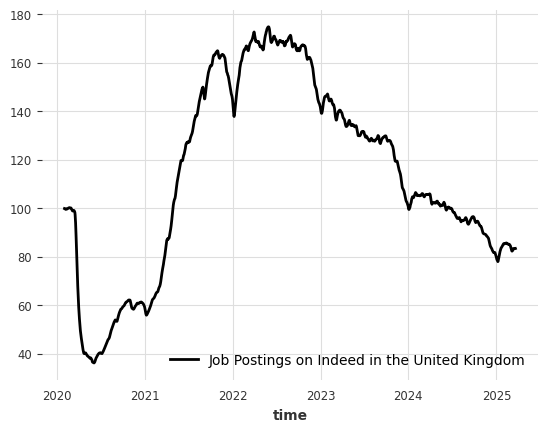

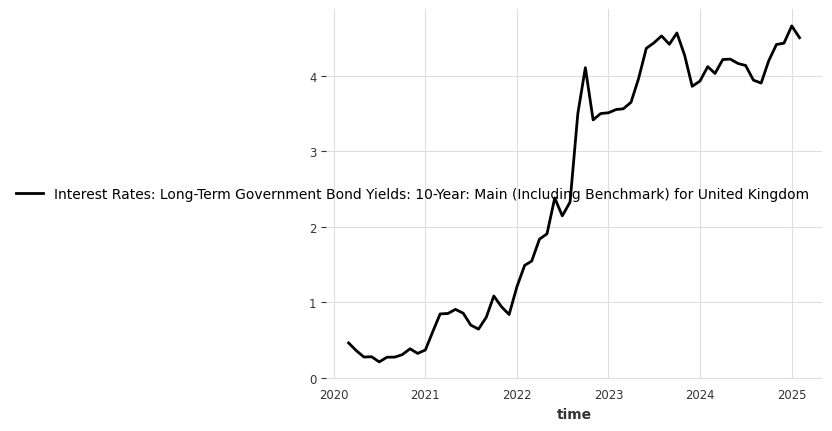

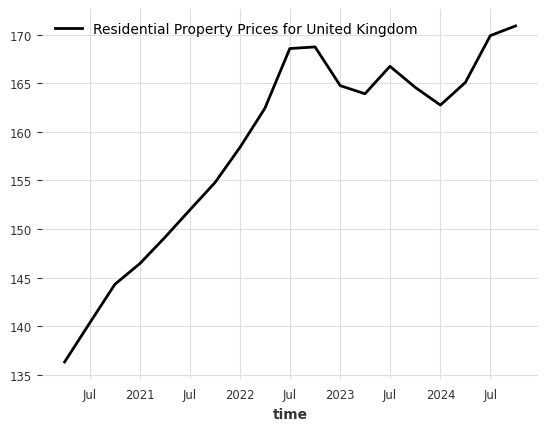

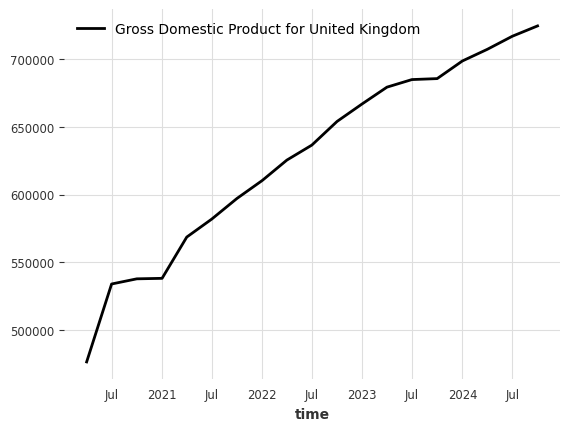

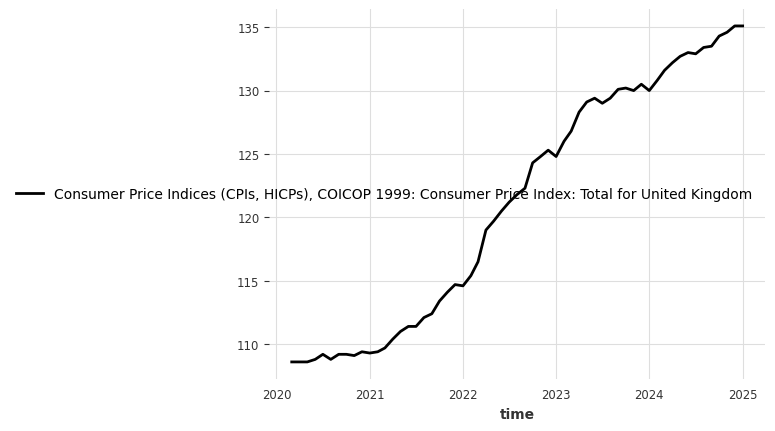

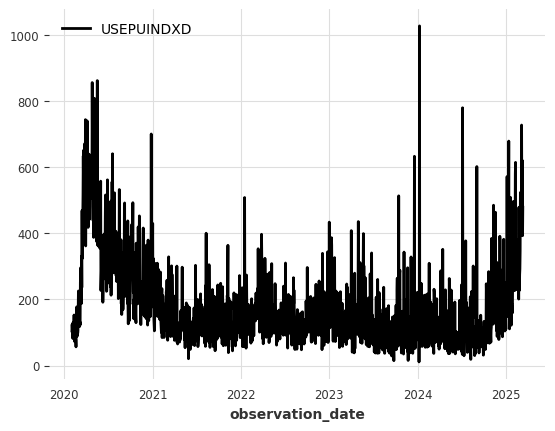

In [35]:
for ts in data_ts:
    ts.drop_before(data_ts[0].start_time()).plot()
    plt.show()

# First experiment: Job Listings on Indeed UK

In [13]:
series = data_ts[0]

In [14]:
# Feature extraction
df = pd.DataFrame(data[0])

In [15]:
df['year'] = df.index.year
df['month'] = df.index.month
df.reset_index(inplace=True)
df['week'] = df['time'].dt.isocalendar().week
df['day'] = df['time'].dt.dayofweek
df['day_str'] = df['time'].dt.strftime('%a')
df['year_month'] = df['time'].dt.strftime('%Y_%m')
df.set_index('time', inplace=True)

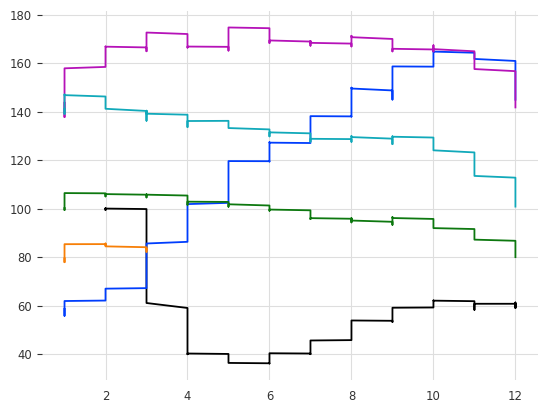

In [16]:
for year in df["year"].unique():
    plt.plot("month", "Job Postings on Indeed in the United Kingdom", data=df[df["year"] == year])
plt.show()

In [17]:
data[0].describe()

count    1876.000000
mean      113.512521
std        39.612707
min        36.200000
25%        85.427500
50%       108.800000
75%       146.292500
max       174.820000
Name: Job Postings on Indeed in the United Kingdom, dtype: float64

In [18]:
train, val = data_ts[0][:-90], data_ts[0][-90:]

In [19]:
from darts.models import ExponentialSmoothing

model = ExponentialSmoothing()
model.fit(train)
prediction = model.predict(len(val), num_samples=1000)

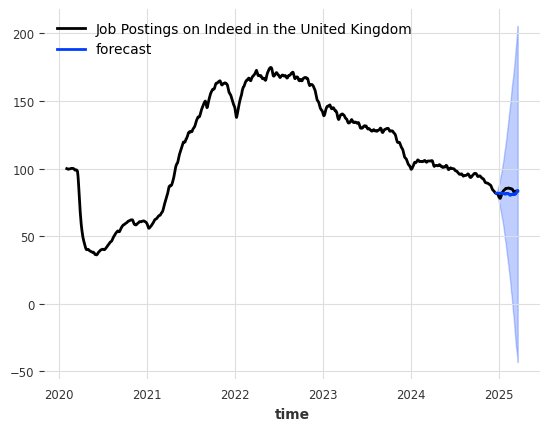

In [20]:
data_ts[0].plot()
prediction.plot(label="forecast", low_quantile=0.05, high_quantile=0.95)
plt.legend()
plt.show()

In [21]:
from darts.ad import KMeansScorer

scorer = KMeansScorer(k=2, window=5)
scorer.fit(train)
anom_score = scorer.score(val)

In [22]:
from darts.ad import QuantileDetector

detector = QuantileDetector(high_quantile=0.99)
detector.fit(scorer.score(train))
binary_anom = detector.detect(anom_score)

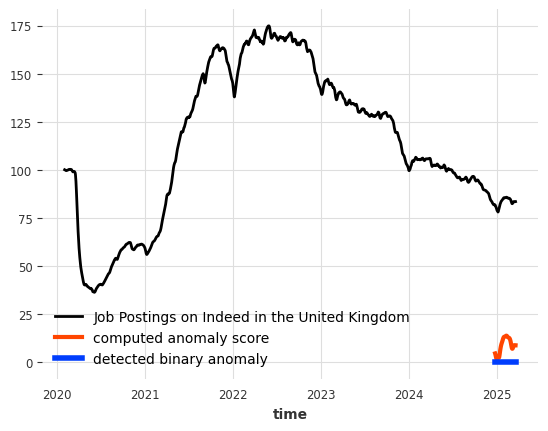

In [23]:
data_ts[0].plot()
(anom_score).plot(label="computed anomaly score", c="orangered", lw=3)
(binary_anom).plot(label="detected binary anomaly", lw=4)
plt.show()